# 3. Working with data

## 3.0 Preamble

At the top of almost every piece of scientific computing work, we'll import these standard modules.

In [1]:
# Import modules, and give them short aliases so we can write e.g. np.foo rather than numpy.foo
import math, random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import pandas
from collections import OrderedDict, namedtuple
# The next line is a piece of magic, to let plots appear in our Jupyter notebooks
%matplotlib inline 

# 3.1 What data looks like

Scientific computing is all about the data. You will almost always work with data in the form of a spreadsheet-like table, often referred to as a _data frame_. 
Here is a example: a sample of rows from a classic dataset (the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), introduced by [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1936; Fisher was described as a "genius who almost single-handedly created the foundations for modern statistical science").

| Sepal.Length | Sepal.Width | Petal.Length | Petal.Width | Species |
|----------------------------------------------------------------|
| 7.7          |        3.8  |         6.7  |        2.2  |  virginica
| 5.3          |        3.7  |         1.5  |        0.2  |     setosa
| 5.8          |        2.7  |         5.1  |        1.9  |  virginica
| 5.5          |        2.4  |         3.7  |        1.0  | versicolor
| 6.7          |        3.0  |         5.2  |        2.3  |  virginica

A data frame is a collection of named columns. Each column has the same length, and all entries in a column have the same type, though different columns may have different types. It is basically the same as a table in a relational database (except that you should think of scientific data tables as logs of observations, which means that the UPDATE and DELETE database operations are irrelevant, and issues about database consistency are irrelevant).

In Python, we have some options about how to store data frames. A simple choice, which we'll use in this notebook, is to store them as dictionaries of `numpy` vectors, e.g.

In [ ]:
iris = {'Sepal.Length': np.array([7.7, 5.3, 5.8, 5.5, 6.7]),
        'Sepal.Width': np.array([3.8, 3.7, 2.7, 2.4, 3.0]),
        'Petal.Length': np.array([6.7, 1.5, 5.1, 3.7, 5.2]),
        'Petal.Width': np.array([2.2, 0.2, 1.9, 1.0, 2.3]),
        'Species': np.array(['virginica', 'setosa', 'virginica', 'versicolor', 'verginica'])}

For example, to extract the rows with `virginica` records,

In [ ]:
i = iris['Species'] == 'virginica'
iris_virginica = {k:v[i] for k,v in iris.items()}

### Special classes for data frames

In _Object Oriented Programming_, you learnt about modularity and encapsulation. Why not design a class to hold data frames? It could provide convenient methods to extract rows etc., and it could incorporate checks e.g. to make sure we don't accidentally set some columns to have different lengths. There are indeed such classes, such as [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) and `numpy`'s [structured arrays](https://docs.scipy.org/doc/numpy/user/basics.rec.html#module-numpy.doc.structured_arrays). (The difference between structured arrays and regular arrays is that in a structured array each column can have a different type.)

You may also have gathered from _Object Oriented Programming_ that good classes are hard to design. In my opinion, neither `pandas.DataFrame` nor structured arrays are mature designs, and by the time you graduate there will probably be something better. That's why, for this course, we will mostly use plain Python dictionaries. There are however three caveats.

* Data import and export has lots of fiddly corner cases. Even printing a data frame takes a surprisingly large amount of code to do well. For these purposes we'll use `pandas.DataFrame`. It also lets you access rows using the standard Python slice notation, e.g. `df[:5]` to get the first five rows.

* For fast numerical computation, and concise code, `numpy` is best as we saw in &sect;2. A number of useful `numpy` routines work on structured arrays. 

* It's nice to keep columns in order, for nice presentation. Python has a special class `collections.OrderedDict` which is like a dictionary except it preserves the order of the keys. When we care about column order, we'll use this rather than plain dictionaries.

Here's another take on the iris dataset:

In [112]:
# Store data frames as OrderedDict, so we can specify the order of the columns
iris = OrderedDict([('Sepal.Length', np.array([7.7, 5.3, 5.8, 5.5, 6.7])),
                    ('Sepal.Width', np.array([3.8, 3.7, 2.7, 2.4, 3.0])),
                    ('Petal.Length', np.array([6.7, 1.5, 5.1, 3.7, 5.2])),
                    ('Petal.Width', np.array([2.2, 0.2, 1.9, 1.0, 2.3])),
                    ('Species', np.array(['virginica', 'setosa', 'virginica', 'versicolor', 'verginica']))])

# Convert it to a pandas.DataFrame for nice printing
pandas.DataFrame(iris)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,7.7,3.8,6.7,2.2,virginica
1,5.3,3.7,1.5,0.2,setosa
2,5.8,2.7,5.1,1.9,virginica
3,5.5,2.4,3.7,1.0,versicolor
4,6.7,3.0,5.2,2.3,verginica


## 3.1 Importing and exporting data

When your data is a very simple comma-separated value (CSV) file then it's very easy to import. A CSV file looks like this:
```
"Sepal.Length","Sepal.Width","Petal.Length","Petal.Width","Species"
5.1,3.5,1.4,0.2,"setosa"
4.9,3,1.4,0.2,"setosa"
4.7,3.2,1.3,0.2,"setosa"
4.6,3.1,1.5,0.2,"setosa"
5,3.6,1.4,0.2,"setosa"
```
i.e. a header line, then one line per row of the data frame, values separated by commas.
Here is code to import a simple CSV file:

In [ ]:
df = pandas.read_csv('data/iris.csv')         # this returns a pandas.DataFrame
df = {col:df[col].values for col in df}       # (optional) convert it to dict of vectors

You can also use `pandas.read_csv` to import data stored on a web server. The following code uses Python's
`with` syntax, which is useful for files and similar objects that need to be closed/released after we've finished with them, to avoid memory leaks. It's equivalent to calling `f=urlopen(my_url)`, then running the other commands, then calling `f.close()`. Here we're loading a CSV from Azure Blob Storage, a convenient place to store files online.

In [ ]:
import urllib.request                         # standard library for web requests
my_url = "https://teachingfiles.blob.core.windows.net/scicomp/flood.csv"
with urllib.request.urlopen(my_url) as f:
    df = pandas.read_csv(f)
    df = {col:df[col].values for col in df}
pandas.DataFrame(df)[:5]                      # show the first 5 rows

**Exercise.** Created an OrderedDict instead of a dictionary.

If your file is nearly a CSV but has some quirks such as comments or a missing header row, experiment with the options in [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) or [`pandas.read_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_table.html). For extreme quirks you may need to use the raw Python [`csv.reader`](https://docs.python.org/3/library/csv.html#csv.reader).

To write a CSV file, it's easiest to use `pandas.DataFrame.to_csv()`. 
In Azure Notebooks, use the Data | Download menu to download the CSV.

In [ ]:
# Convert a dictionary of vectors into pandas.DataFrame
x = pandas.DataFrame(df)
# Write it to a file. Pandas likes to add a column with row numbers, which index=False suppresses.
x.to_csv('data/temp.csv', index=False)

In my experience, around 75% of the time you spend working with data will be fighting to import it and clean it up. For the most part this is just general-purpose programming, but there are a few library routines that will save you from reinventing the wheel. See
[&sect;A. Data import and cleanup](A.%20Data%20import%20and%20cleanup.ipynb) for a collection of recipes for

* [reading from a URL](A.%20Data%20import%20and%20cleanup.ipynb#readurl)
* [parsing a log file using regular expressions](A.%20Data%20import%20and%20cleanup.ipynb#regexp)
* [reading JSON from a web service](A.%20Data%20import%20and%20cleanup.ipynb#json)
* [scraping a website with XPath](A.%20Data%20import%20and%20cleanup.ipynb#xpath)
* [reading from an SQL database](A.%20Data%20import%20and%20cleanup.ipynb#sql)

## 3.2 Simple data handling

* summary(data.frame)
* * numeric: quantiles, histogram
* * factor: tabulation, bar chart
* cross tabulation, aggregation, facets
* joining: per-station summaries
* pivotting

In [2]:
import urllib.request
my_url = "https://teachingfiles.blob.core.windows.net/scicomp/flood.csv"
with urllib.request.urlopen(my_url) as f:
    flood = pandas.read_csv(f)
    flood = OrderedDict((k, flood[k].values) for k in flood)

View some rows

In [6]:
pandas.DataFrame(flood)[:3]

,label,id,lat,lng,town,river,measure_id,qualifier,parameter,period,low,high,valuetype,t,value
0,Cambridge Jesus Lock,E60501,52.212835,0.120872,Cambridge,River Cam,1702,Stage,Water Level,900.0,0.637,0.74,instantaneous,2017-08-07T07:00:00Z,0.680
1,Cambridge Jesus Lock,E60501,52.212835,0.120872,Cambridge,River Cam,1702,Stage,Water Level,900.0,0.637,0.74,instantaneous,2017-08-07T00:45:00Z,0.682
2,Cambridge Jesus Lock,E60501,52.212835,0.120872,Cambridge,River Cam,1702,Stage,Water Level,900.0,0.637,0.74,instantaneous,2017-08-07T04:00:00Z,0.681


## Univariate stats

In [3]:
import IPython.display
class SummaryNumeric(namedtuple('SummaryNumeric', ['min','q25','med','mean','q75','max','nan'])):
    def _repr_html_(self):
        res = '<pre>'
        res += 'min:  {}\n'.format(self.min)
        res += '25%:  {}\n'.format(self.q25)
        res += 'med:  {}\n'.format(self.med)
        res += 'mean: {}\n'.format(self.mean)
        res += '75%:  {}\n'.format(self.q75)
        res += 'max:  {}'.format(self.max)
        if self.nan > 0:
            res += '\n(nan): {}'.format(self.nan)
        res += '</pre>'
        return res
class SummaryCategorical(list):
    def __init__(self, some_counts, other):
        list.__init__(self, some_counts)
        self.other = other
    def _repr_html_(self):
        res = '<pre>'
        res += '\n'.join('{v}: {n}'.format(v=v, n=n) for v,n in self)
        if self.other > 0:
            res += '\n(other): {n}'.format(n=self.other)
        res += '</pre>'
        return res
class SummaryTable(dict):
    def _repr_html_(self):
        res = ''
        for colname, details in self.items():
            res += '<div style="display: inline-block; font-size: 90%; background-color: rgb(240,240,240); margin: 0.5em; padding: 0.2em; vertical-align: top">'
            res += '<strong>' + colname + '</strong>'
            res += details._repr_html_()
            res += '</div>'
        return res
def summary(df):
    got_dict = isinstance(df, dict)
    if not got_dict:
        df = {None: df}
    res = OrderedDict()
    for colname, col in df.items():
        if np.issubdtype(col.dtype, np.number):
            q = np.nanpercentile(col, q=[0,25,50,75,100])
            res[colname] = SummaryNumeric(min=q[0], q25=q[1], med=q[2], q75=q[3], max=q[4],
                                          mean = np.nanmean(col),
                                          nan = np.count_nonzero(np.isnan(col)))
        else:
            vs,ns = np.unique(col, return_counts=True)
            i = np.argsort(-ns)[:5]
            res[colname] = SummaryCategorical(zip(vs[i], ns[i]), max(0, len(col)-sum(ns[i])))
    return SummaryTable(res) if got_dict else res[None]

In [4]:
summary(flood)

{'high': SummaryNumeric(min=0.29399999999999998, q25=0.36799999999999999, med=0.59999999999999998, mean=0.63282764753435727, q75=0.78200000000000003, max=1.25, nan=0),
 'id': [('2514', 2665),
  ('E19035', 2665),
  ('52113', 2657),
  ('E60101', 2653),
  ('E60501', 2653)],
 'label': [('Bin Brook', 2665),
  ('Cam', 2665),
  ('Weston Bampfylde', 2657),
  ('Cambridge Baits Bite', 2653),
  ('Cambridge Jesus Lock', 2653)],
 'lat': SummaryNumeric(min=51.023159, q25=51.699984999999998, med=52.134461999999999, mean=51.890147147291827, q75=52.212834999999998, max=52.236542, nan=0),
 'lng': SummaryNumeric(min=-2.5655679999999998, q25=-2.3622179999999999, med=0.087526999999999994, mean=-0.96795750105092959, q75=0.14178399999999999, max=0.176925, nan=0),
 'low': SummaryNumeric(min=0.026000000000000002, q25=0.057000000000000002, med=0.14099999999999999, mean=0.25518598760441935, q75=0.57799999999999996, max=0.63700000000000001, nan=0),
 'measure_id': SummaryNumeric(min=919.0, q25=1455.0, med=1702.0, mean=1584.3469145782808, q75=1792.0, max=1865.0, nan=0),
 'parameter': [('Water Level', 18555)],
 'period': SummaryNumeric(min=900.0, q25=900.0, med=900.0, mean=900.0, q75=900.0, max=900.0, nan=0),
 'qualifier': [('Stage', 18555)],
 'river': [('River Cam', 15890), ('Bin Brook', 2665)],
 't': [('2017-08-07T00:00:00Z', 7),
  ('2017-08-25T03:15:00Z', 7),
  ('2017-08-25T03:30:00Z', 7),
  ('2017-08-25T03:45:00Z', 7),
  ('2017-08-25T04:00:00Z', 7)],
 'town': [('Cambridge', 7963),
  ('Cam', 2665),
  ('Weston Bampfylde', 2657),
  ('Milton', 2653),
  ('Great Shelford', 2617)],
 'value': SummaryNumeric(min=-1.3, q25=0.095000000000000001, med=0.17399999999999999, mean=0.31475308575432548, q75=0.66799999999999993, max=0.91500000000000004, nan=2),
 'valuetype': [('instantaneous', 18555)]}

Cleanup

In [104]:
flood2 = flood.copy()
flood2['measure_id'] = flood2['measure_id'].astype(str)
summary(flood2['measure_id'])

[('1636', 2665), ('1792', 2665), ('919', 2657), ('1455', 2653), ('1702', 2653)]

## Univariate plots

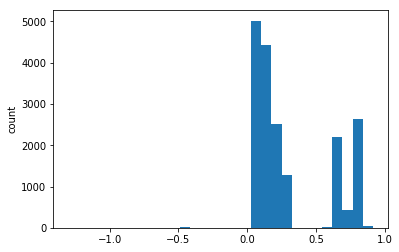

In [131]:
plt.hist(flood['value'][~np.isnan(flood['value'])], bins=30)
plt.ylabel('count')
plt.show()

In [ ]:
vs, ns = np.unique(df['river'], return_counts=True)
xs = np.arange(len(vs))
plt.bar(xs, ns, align='center')
plt.xticks(xs, vs, rotation=-90)
plt.ylabel('count')
plt.title('river')
plt.show()

In [ ]:
vs, ns = np.unique(np.vstack([df['lat'],df['lng']]).T, return_counts=True, axis=0)
vs

In [ ]:
ns

In [ ]:
!pip3 install gmplot -q
import gmplot
import tempfile, webbrowser

In [ ]:
gmap = gmplot.GoogleMapPlotter(52.212, 0.1208, 16)
for x,y,r in zip(vs[:,0],vs[:,1],ns):
    gmap.circle(x,y,r/10)

with tempfile.NamedTemporaryFile(delete=False, suffix='.html') as f:
    gmap.draw(f.name)
    webbrowser.open('file://' + f.name)

### Cuts

In [105]:
x = (flood['value'] - flood['low']) / (flood['high'] - flood['low'])
summary(x)

SummaryNumeric(min=-2.3101045296167251, q25=0.027953110910730387, med=0.27652733118971068, mean=0.30981046729285844, q75=0.43729903536977494, max=1.6519607843137254, nan=2)

In [106]:
y = np.digitize(x, bins=np.nanpercentile(x, [100/3, 200/3])).astype(str)
y[np.isnan(x)]

array(['2', '2'],
      dtype='<U21')

In [111]:
def cut(x, breaks, labels=None):
    if not isinstance(breaks, list):
        breaks = np.nanpercentile(x, [100/(breaks+1)*i for i in range(1, (breaks+1))])
    if len(np.unique(breaks)) < len(breaks):
        raise Exception("Breaks are not unique")
    y = np.digitize(x, breaks)
    y[np.isnan(x)] = -1
    if labels is None:
        breaks2 = ['-inf'] + different_digits(breaks) + ['inf']
        labels = ['{}{}, {})'.format('(' if i==0 else '[',l,h) for i,(l,h) in enumerate(zip(breaks2[:-1], breaks2[1:]))]
    else:
        if len(labels) != len(breaks) + 1:
            raise Exception('labels should have length {}, not {}'.format(len(labels), len(breaks)+1))
    return np.take(['nan'] + labels, y+1)
summary(cut(x, breaks=2, labels=['low','med','high']))

[('med', 6244), ('high', 6190), ('low', 6119), ('nan', 2)]

In [38]:
def different_digits(x, digits=None):
    if digits is None:
        digits = max(-math.floor(math.log(min(x), 10)) + 1, 0)
    for d in range(digits, max(12, digits)):
        fmt = '{:.' + str(d) + 'f}'
        s = [fmt.format(xx) for xx in x]
        if len(set(s)) == len(s):
            return s
    return [str(xx) for xx in x]
different_digits([2,5,10])

['2.0', '5.0', '10.0']

## Numerical aggregation. Cross tabs. Facet plots.

For each measure: number of readings, mean and std.dev

In [ ]:
res = {'measure_id':[], 'n':[], 'mean':[], 'sd':[]}
for m in np.unique(df['measure_id']):
    i = df['measure_id'] == m
    # Exercise: a better way to get indexes: https://stackoverflow.com/a/23271510
    res['measure_id'].append(m)
    res['n'].append(np.count_nonzero(i))
    res['mean'].append(np.nanmean(df['value'][i]))
    res['sd'].append(np.nanstd(df['value'][i]))

xs = np.arange(len(res['measure_id']))
plt.bar(xs, res['mean'], align='center')
plt.errorbar(xs, res['mean'], yerr=res['sd'], linestyle='None', ecolor='k')
plt.xticks(xs, res['measure_id'], rotation=-90)
plt.ylabel('value')
plt.xlabel('measure_id')
plt.show()

### Cross tabs

In [120]:
def crosstab(df, cols, countlabel='n'):
    x = np.rec.fromarrays([df[col] for col in cols], names=cols)
    vs, ns = np.unique(x, return_counts=True)
    x = OrderedDict((k,vs[k]) for k in vs.dtype.names)
    if countlabel is not None:
        x[countlabel] = ns
    return x

In [122]:
pandas.DataFrame(crosstab(flood, ['label','measure_id']))

,label,measure_id,n
0,Bin Brook,1792,2665
1,Cam,1636,2665
2,Cambridge,1865,2645
3,Cambridge Baits Bite,1455,2653
4,Cambridge Jesus Lock,1702,2653
5,Dernford,1724,2617
6,Weston Bampfylde,919,2657


In [123]:
# Question. Is there one label/measure_id per town:river?
x = crosstab(flood, ['town','river','measure_id'])
y = crosstab(x, ['town','river'], countlabel='num_measures')
pandas.DataFrame(y)

,town,river,num_measures
0,Cam,River Cam,1
1,Cambridge,Bin Brook,1
2,Cambridge,River Cam,2
3,Great Shelford,River Cam,1
4,Milton,River Cam,1
5,Weston Bampfylde,River Cam,1


## Facet plots

Time series, one line per station

In [22]:
import datetime, pytz
local_tz = pytz.timezone('Europe/London')
flood['t2'] = np.array([datetime.datetime.strptime(xx, '%Y-%m-%dT%H:%M:%SZ').replace(tzinfo=pytz.utc).astimezone(local_tz)
               for xx in flood['t']])

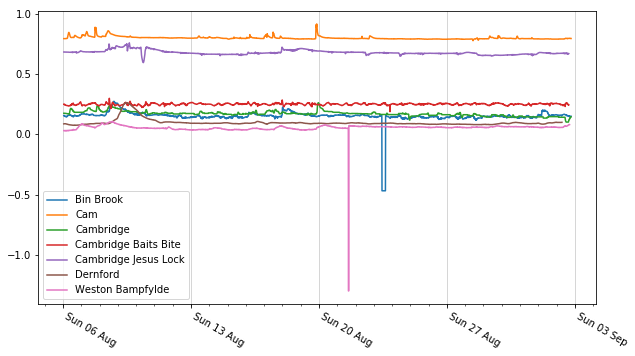

In [44]:
i = np.argsort(flood['t2'])
flood_sorted = {k:v[i] for k,v in flood.items()}
labels = np.unique(flood['label'])

with matplotlib.rc_context({'figure.figsize': [10,6]}):
    fig,ax = plt.subplots()
    for lbl in labels:
        i = flood_sorted['label'] == lbl
        ax.plot(flood_sorted['t2'][i], flood_sorted['value'][i], linestyle='-', label=lbl)
    ax.legend()
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.MO, tz=local_tz))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator(tz=local_tz))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%a %d %b'))
    ax.grid(True, axis='x', color='0.8')
    fig.autofmt_xdate(bottom=0.2, rotation=-30, ha='left')

# https://matplotlib.org/examples/api/date_demo.html

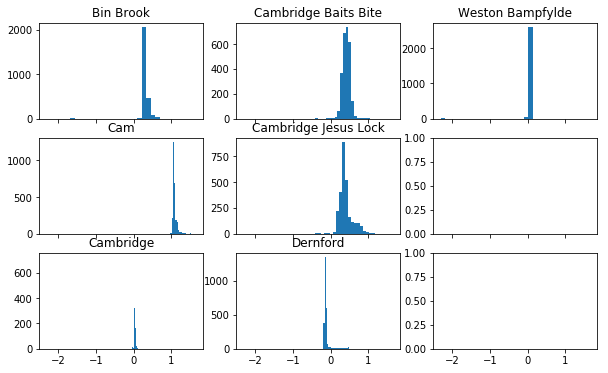

In [145]:
norm_value = (flood['value'] - flood['low']) / (flood['high'] - flood['low'])

with matplotlib.rc_context({'figure.figsize': [10,6]}):
    fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True)
    for i,lbl in enumerate(np.unique(flood['label'])):
        ax = axes[i % len(axes), i // len(axes)]
        x = norm_value[flood['label'] == lbl]
        x = x[~np.isnan(x)]
        ax.hist(x, bins=20)
        ax.set_title(lbl)

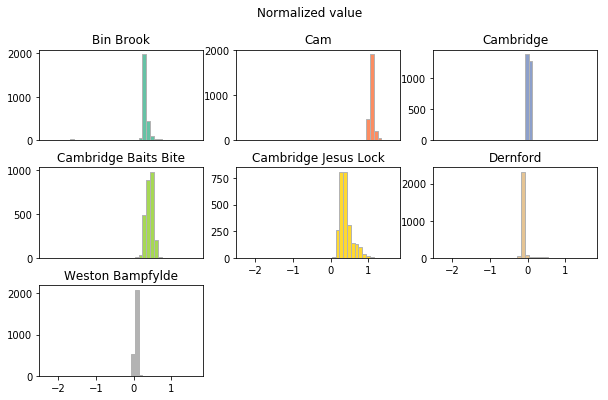

In [199]:
labels = np.unique(flood['label'])
norm_value = (flood['value'] - flood['low']) / (flood['high'] - flood['low'])
bins = np.linspace(min(norm_value), max(norm_value), 40)

with matplotlib.rc_context({'figure.figsize': [10,6], 'figure.subplot.hspace': 0.3}):
    colors = plt.get_cmap('Set2', len(labels))
    fig = plt.figure()
    ax0 = None
    for i,lbl in enumerate(labels):
        if ax0 is None:
            ax = fig.add_subplot(3, 3, i+1)
            ax0 = ax
        else:
            ax = fig.add_subplot(3, 3, i+1, sharex=ax0)
        x = norm_value[flood['label'] == lbl]
        x = x[~np.isnan(x)]
        ax.hist(x, bins=bins, facecolor=colors(i), edgecolor='0.7')
        ax.set_title(lbl)
        if i + 3 < len(labels):
            ax.get_xaxis().set_visible(False)
    fig.suptitle('Normalized value')
            
# https://matplotlib.org/users/customizing.html
# https://matplotlib.org/api/axes_api.html
# https://matplotlib.org/users/colormaps.html